In [1]:
from pathlib import Path
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import re
from gelgenie.segmentation.helper_functions.general_functions import create_dir_if_empty
from collections import defaultdict

In [2]:
# reads in data and creates two new columns for easy differentation between GG and GA raw volumes
input_folder = Path('C:/Users/s1893121/Desktop/')

main_df = pd.read_csv(join(input_folder,'merged_df.csv'))
main_df['Normalized_GG Raw Difference'] = np.nan
main_df['Normalized_GA Raw Difference'] = np.nan
main_df['Normalized_GG Raw Difference'] = main_df.apply(lambda row: row['Raw Difference'] if row['App'] == 'GG' else np.nan, axis=1)
main_df['Normalized_GA Raw Difference'] = main_df.apply(lambda row: row['Raw Difference'] if row['App'] == 'GA' else np.nan, axis=1)
main_df = main_df.rename(columns={'Normalized_Background Corrected Volume': 'GA Normalized_Background Corrected Volume'})
main_df = main_df.rename(columns={'Background Difference': 'GA Background Difference'})
main_df

,Lane ID,Band ID,Pixel Count,Average Intensity,Raw Volume,Local Corrected Volume,Global Corrected Volume,Rolling Ball Corrected Volume,Normalized_Raw Volume,Normalized_Local Corrected Volume,...,Intensity,Normalized_Intensity,Expected Value,Raw Difference,Local Difference,Global Difference,GA Background Difference,Rolling Ball Difference,Normalized_GG Raw Difference,Normalized_GA Raw Difference
0,1,1,376.0,26.015957,9782.0,4856.063857,5297.103333,5709.0,0.000000,0.050952,...,20.0,0.000000,0.000000,0.000000,0.050952,0.000000,NaN,0.000000,0.000000,NaN
1,1,2,409.0,30.677262,12547.0,7064.778191,7668.482083,7974.0,0.124927,0.170629,...,20.0,0.000000,0.000000,0.124927,0.170629,0.116156,NaN,0.112889,0.124927,NaN
2,1,3,367.0,31.940054,11722.0,6146.662321,7344.454583,7341.0,0.087652,0.120882,...,20.0,0.000000,0.000000,0.087652,0.120882,0.100285,NaN,0.081340,0.087652,NaN
3,1,4,351.0,33.413105,11728.0,5660.595745,7541.301250,7412.0,0.087923,0.094545,...,20.0,0.000000,0.000000,0.087923,0.094545,0.109927,NaN,0.084878,0.087923,NaN
4,1,5,395.0,30.524051,12057.0,6270.890274,7345.472917,7412.0,0.102788,0.127613,...,20.0,0.000000,0.000000,0.102788,0.127613,0.100335,NaN,0.084878,0.102788,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10151,12,15,NaN,NaN,3145.0,NaN,NaN,NaN,1.000000,NaN,...,124.0,1.000000,1.000000,0.000000,NaN,NaN,-0.066560,NaN,NaN,0.000000
10152,12,16,NaN,NaN,1802.0,NaN,NaN,NaN,0.307375,NaN,...,49.0,0.257426,0.257426,0.049949,NaN,NaN,-0.031283,NaN,NaN,0.049949
10153,12,17,NaN,NaN,1751.0,NaN,NaN,NaN,0.281073,NaN,...,37.0,0.138614,0.138614,0.142459,NaN,NaN,0.003327,NaN,NaN,0.142459
10154,12,18,NaN,NaN,1394.0,NaN,NaN,NaN,0.096957,NaN,...,32.0,0.089109,0.089109,0.007848,NaN,NaN,-0.027361,NaN,NaN,0.007848


### Full Dataset Plots

In [3]:
# melts df again - useful for violin plots
melted_df = pd.melt(main_df, id_vars=['Lane ID', 'Band ID', 'Gel ID', 'App'],
                    value_vars=['Normalized_GG Raw Difference',
                                'Normalized_GA Raw Difference',
                                'GA Background Difference',
                                'Local Difference', 'Global Difference',
                                'Rolling Ball Difference'],
                    var_name='Variable', value_name='Error')

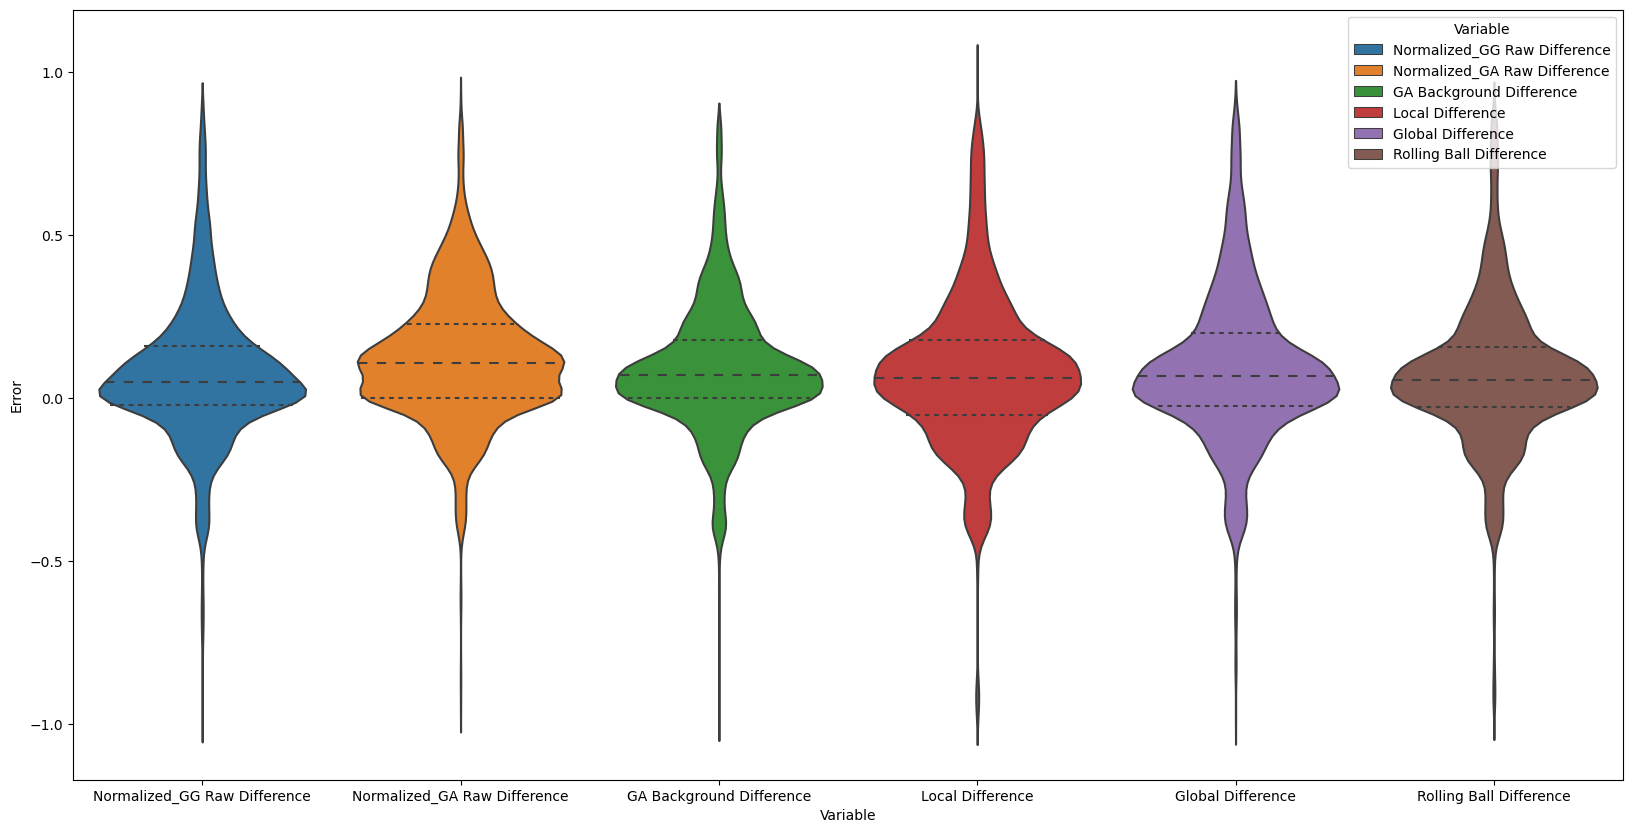

In [4]:
# violin plot comparing error values for entire dataset - it appears the best one might be raw GG but differences are quite small
plt.figure(figsize=(20,10))
sns.violinplot(data=melted_df, x='Variable', y='Error', hue='Variable', inner='quart',dodge=False)
pass

### Gel-Level Graphs

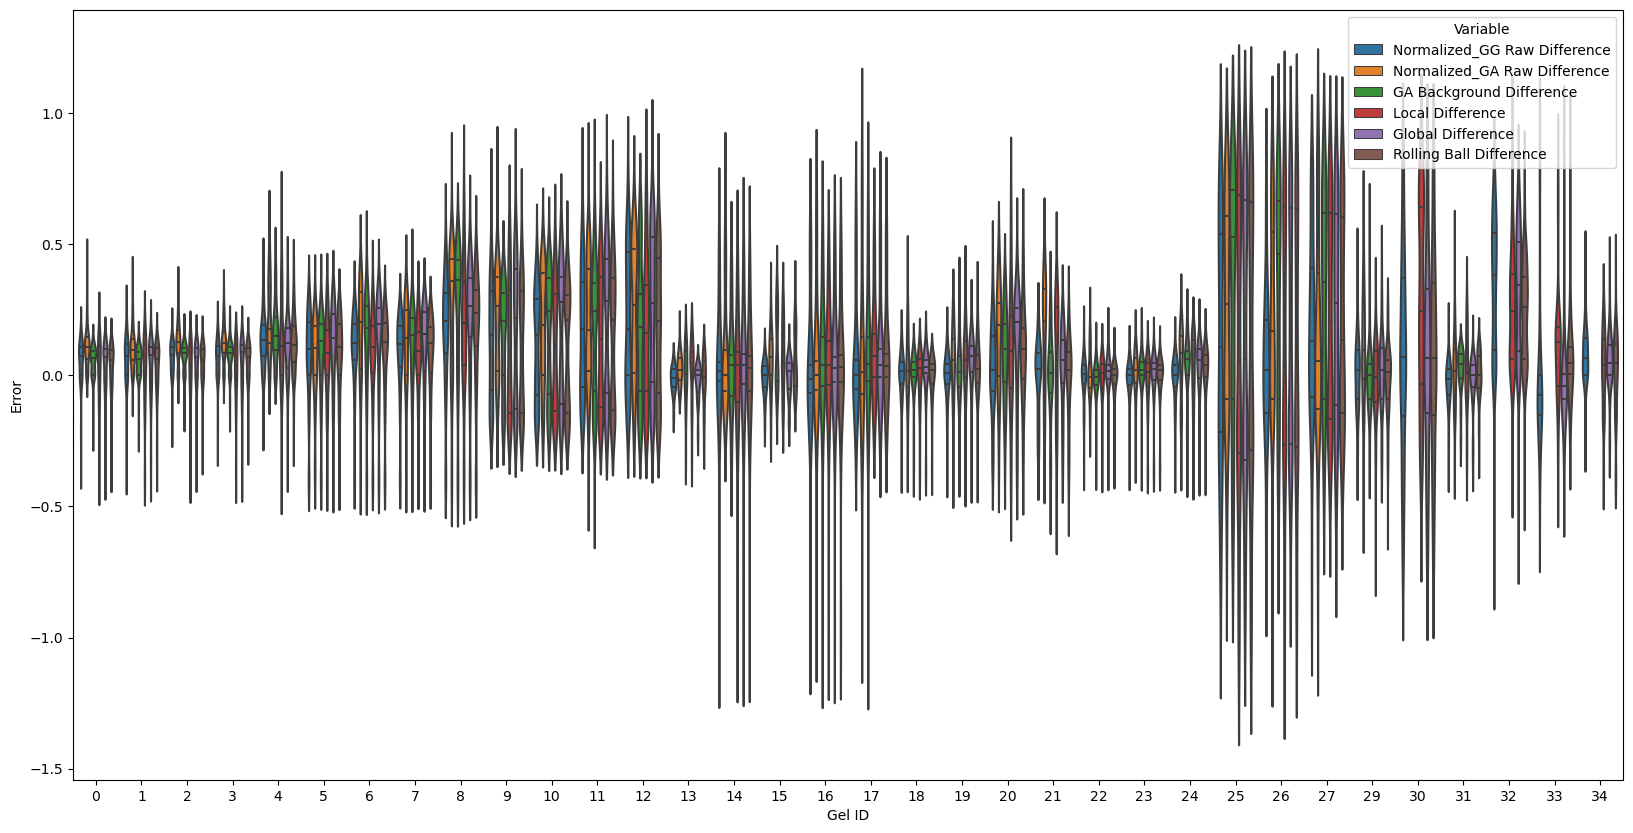

In [5]:
# violin plot comparing error values for each gel - difficult to deciper but shows obvious differences between different gels in the dataset
plt.figure(figsize=(20,10))
sns.violinplot(data=melted_df, x='Gel ID', y='Error', hue='Variable', inner='quart',dodge=True)
pass

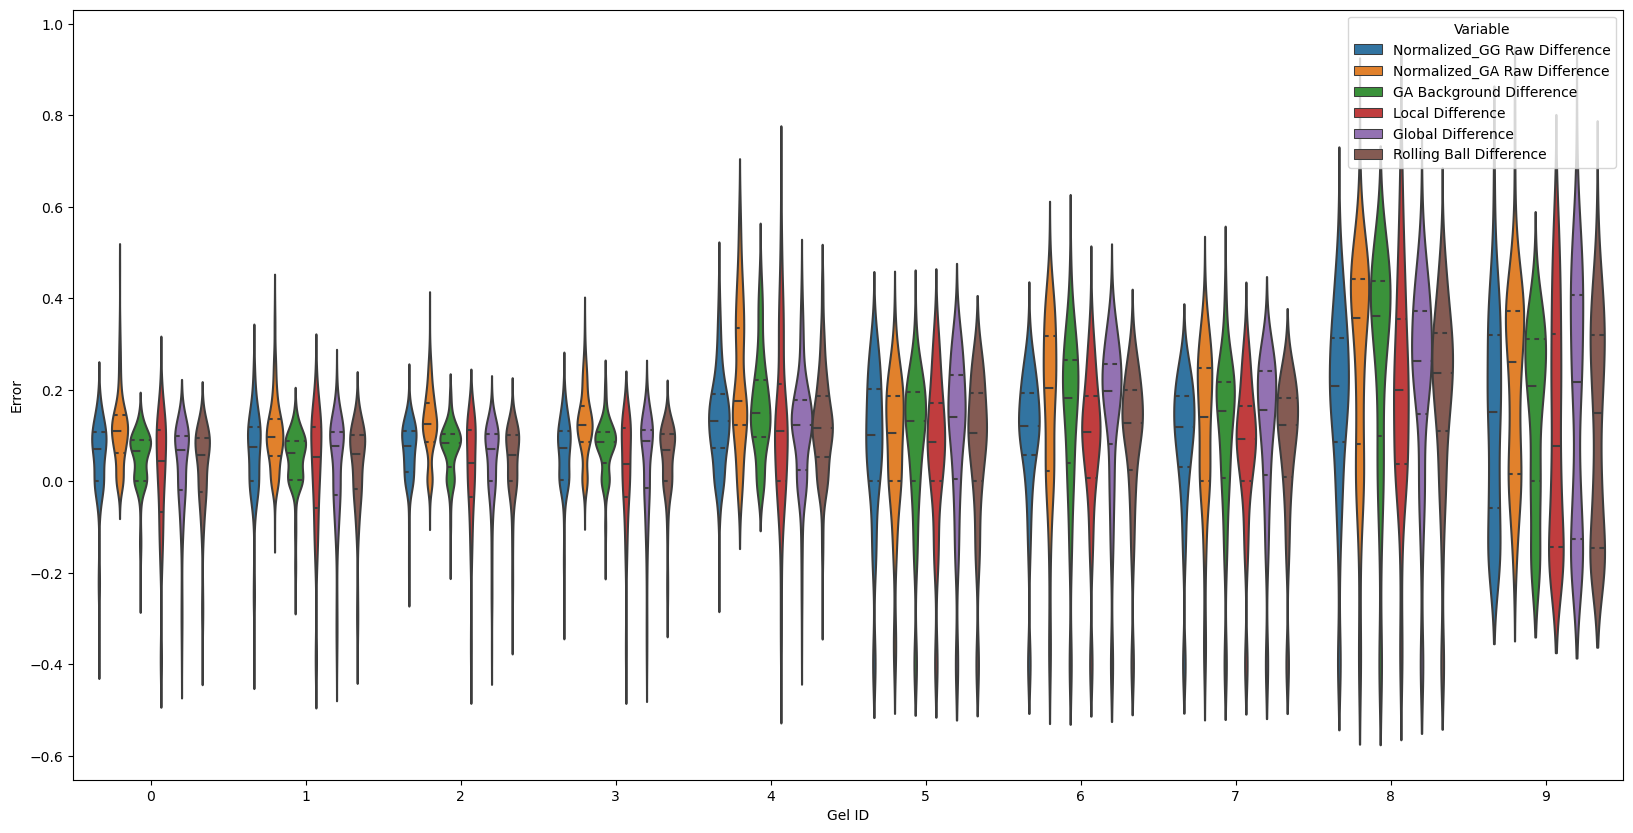

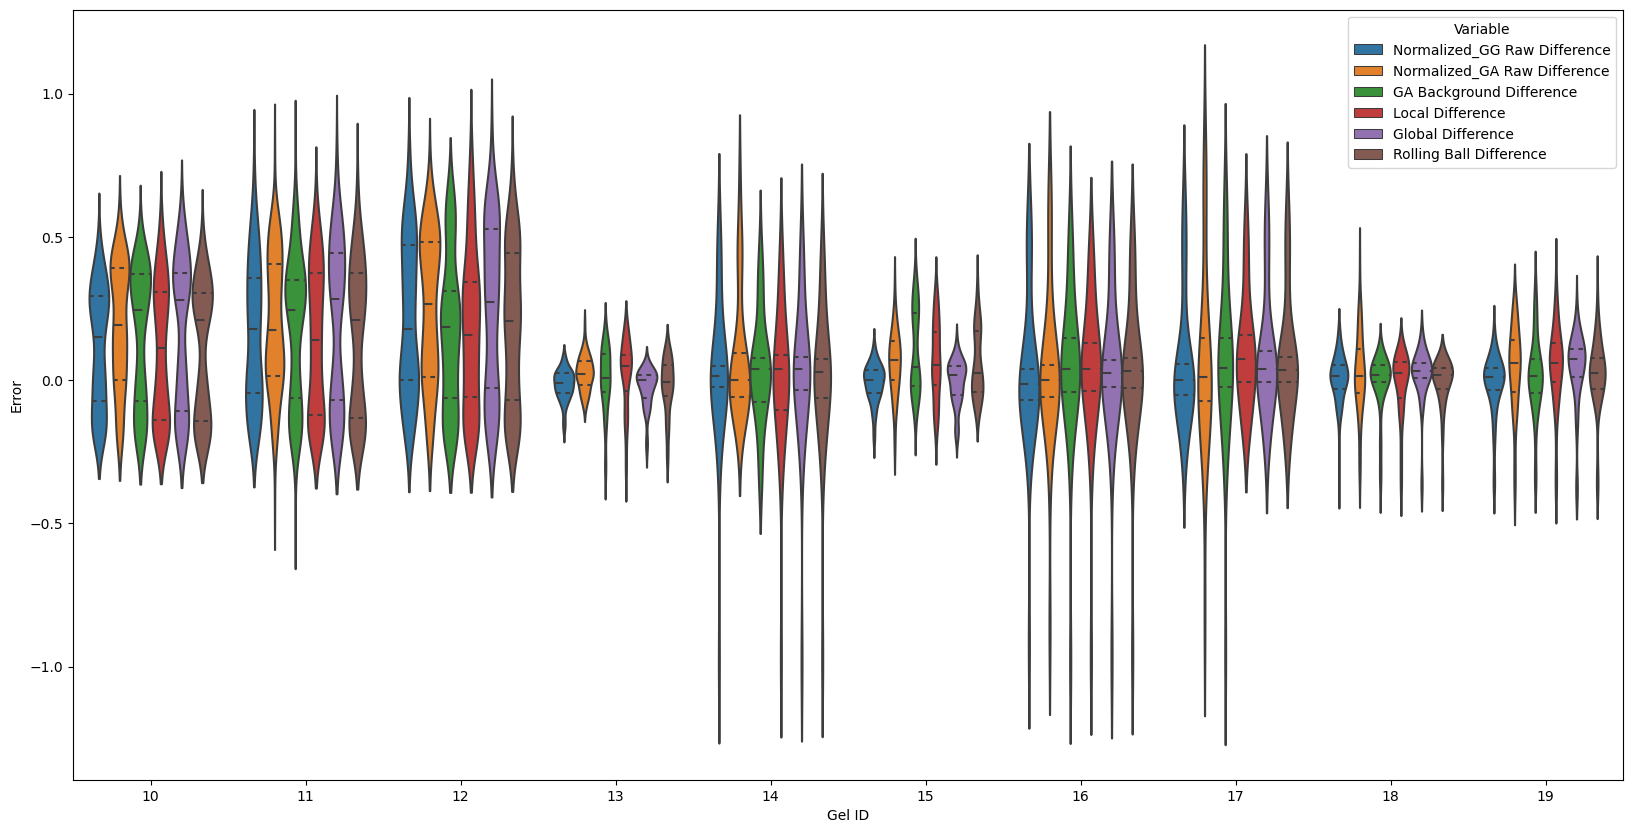

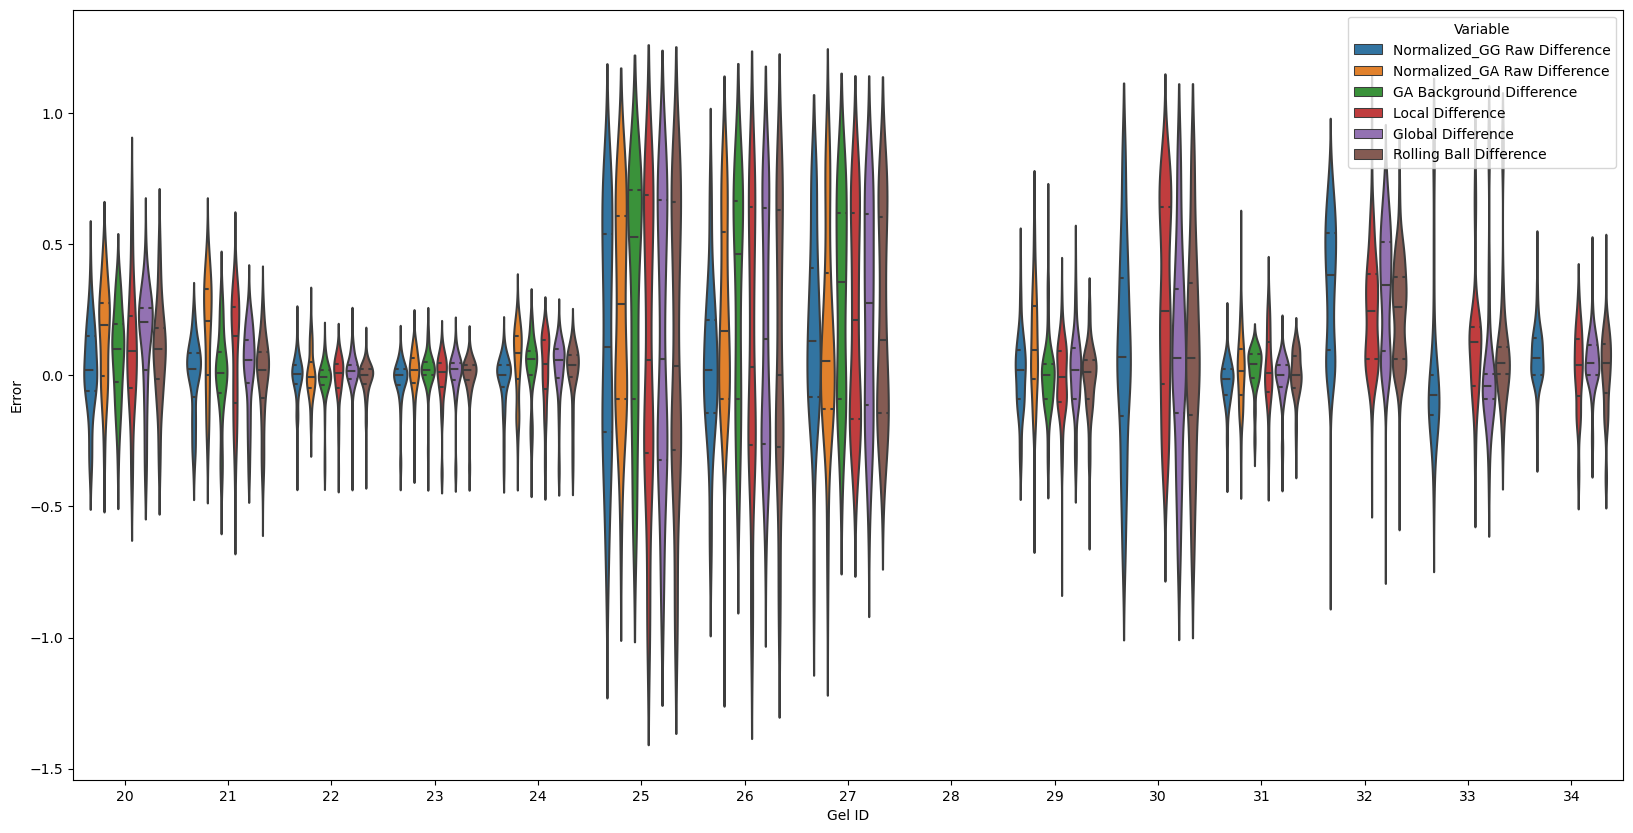

In [6]:
# more manageable violin plot chunks -  again distinction between methods is not super clear
plt.figure(figsize=(20,10))
order_plot = list(range(0,10))
sns.violinplot(data=melted_df, x='Gel ID', y='Error', hue='Variable', inner='quart',dodge=True, order=order_plot)

plt.figure(figsize=(20,10))
order_plot = list(range(10,20))
sns.violinplot(data=melted_df, x='Gel ID', y='Error', hue='Variable', inner='quart',dodge=True, order=order_plot)

plt.figure(figsize=(20,10))
order_plot = list(range(20,35))
sns.violinplot(data=melted_df, x='Gel ID', y='Error', hue='Variable', inner='quart',dodge=True, order=order_plot)
pass

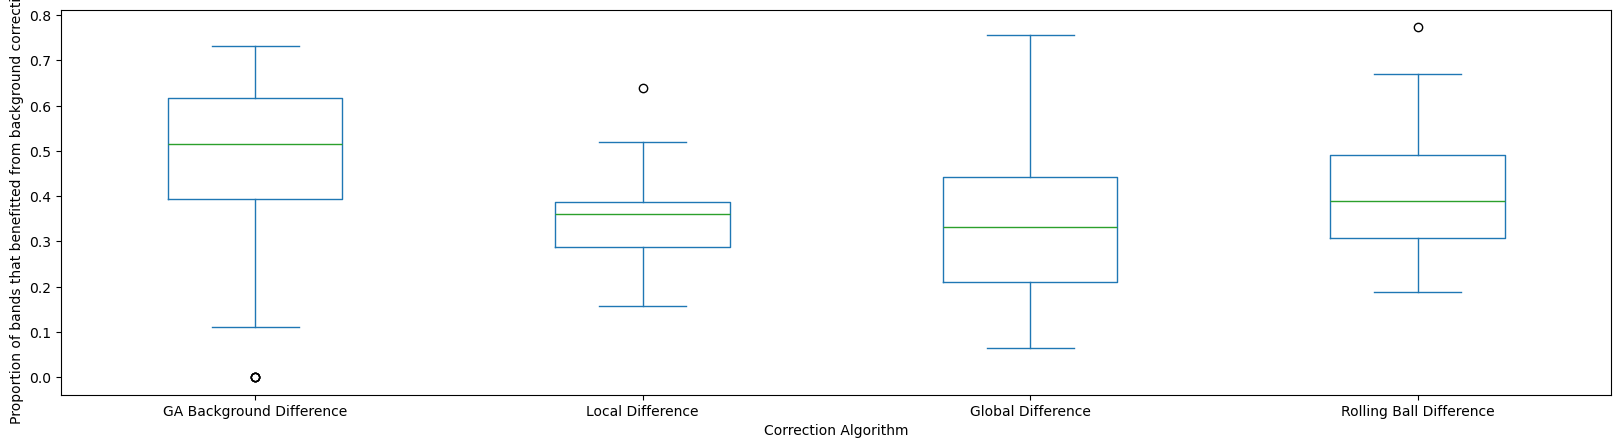

In [7]:
# this graph shows that gelanalyzer's background correction algorithm is more often than not useful, while gelgenie's methods are less frequently helpful

sel_quantities = [  'GA Background Difference',
                    'Local Difference', 'Global Difference',
                    'Rolling Ball Difference']

data_package = defaultdict(list)

for gel in main_df['Gel ID'].unique():
    filt_df = main_df[main_df['Gel ID']==gel]
        
    for i, q in enumerate(sel_quantities):
        if 'GA ' in q:
            data_series = abs(filt_df['Normalized_GA Raw Difference']) - abs(filt_df[q])
            max_val_ga = len(filt_df[filt_df['App'] == 'GA'])
            if max_val_ga == 0:
                data_package[q].append(0)
            else:
                data_package[q].append((data_series > 0).sum()/max_val_ga)

        else:
            data_series = abs(filt_df['Normalized_GG Raw Difference']) - abs(filt_df[q])
            max_val_gg = len(filt_df[filt_df['App'] == 'GG'])
            if max_val_gg == 0:
                data_package[q].append(0)
            else:
                data_package[q].append((data_series > 0).sum()/max_val_gg)


out_dict = pd.DataFrame.from_dict(data_package) 
fig, ax = plt.subplots(figsize=(20,5))
out_dict.plot(kind='box',ax=ax)
plt.xlabel('Correction Algorithm')
plt.ylabel('Proportion of bands that benefitted from background correction')
pass

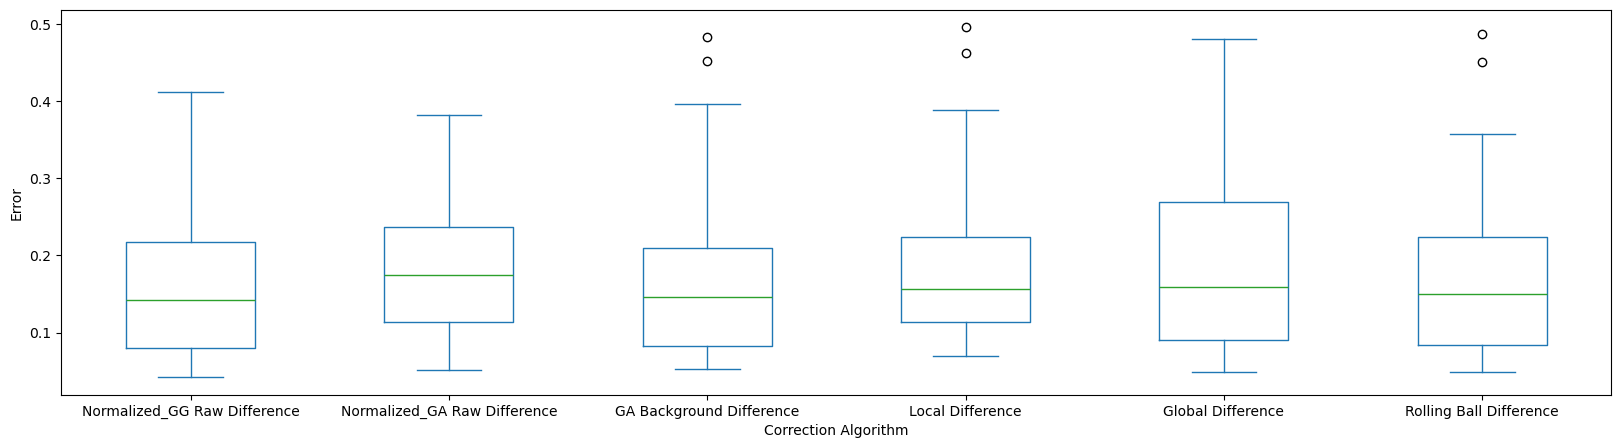

In [8]:
# this graph again seems to imply that most of the results are similar to each other
sel_quantities = [  'Normalized_GG Raw Difference',
                  'Normalized_GA Raw Difference',
                    'GA Background Difference',
                    'Local Difference', 
                  'Global Difference',
                    'Rolling Ball Difference']

data_package = defaultdict(list)

for gel in main_df['Gel ID'].unique():
    filt_df = main_df[main_df['Gel ID']==gel]
        
    for i, q in enumerate(sel_quantities):
        data_package[q].append(abs(filt_df[q]).mean())

out_dict = pd.DataFrame.from_dict(data_package) 
fig, ax = plt.subplots(figsize=(20,5))
out_dict.plot(kind='box',ax=ax)
plt.xlabel('Correction Algorithm')
plt.ylabel('Error')
pass

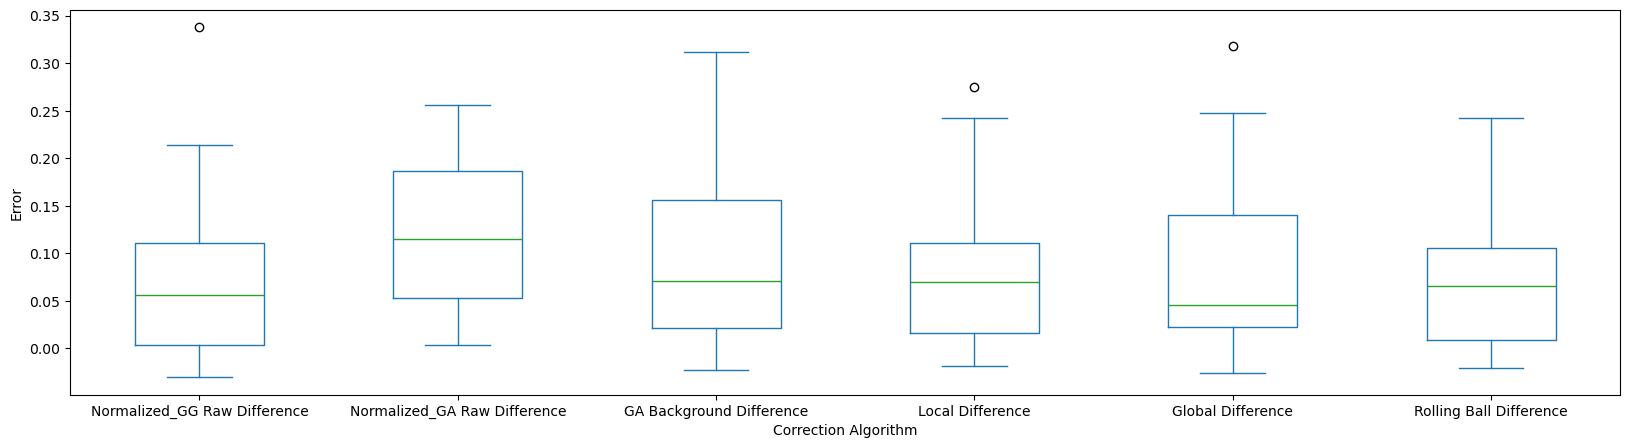

In [15]:
# this graph again seems to imply that most of the results are similar to each other
sel_quantities = [  'Normalized_GG Raw Difference',
                  'Normalized_GA Raw Difference',
                    'GA Background Difference',
                    'Local Difference', 
                  'Global Difference',
                    'Rolling Ball Difference']

data_package = defaultdict(list)

for gel in main_df['Gel ID'].unique():
    filt_df = main_df[main_df['Gel ID']==gel]
        
    for i, q in enumerate(sel_quantities):
        data_package[q].append(filt_df[q].mean())

out_dict = pd.DataFrame.from_dict(data_package) 
fig, ax = plt.subplots(figsize=(20,5))
out_dict.plot(kind='box',ax=ax)
plt.xlabel('Correction Algorithm')
plt.ylabel('Error')
pass

In [9]:
out_dict.mean() # Raw GG has the best overall average error!

Normalized_GG Raw Difference    0.157189
Normalized_GA Raw Difference    0.182492
GA Background Difference        0.172937
Local Difference                0.185743
Global Difference               0.181189
Rolling Ball Difference         0.167893
dtype: float64

### Lane-Level Graphs

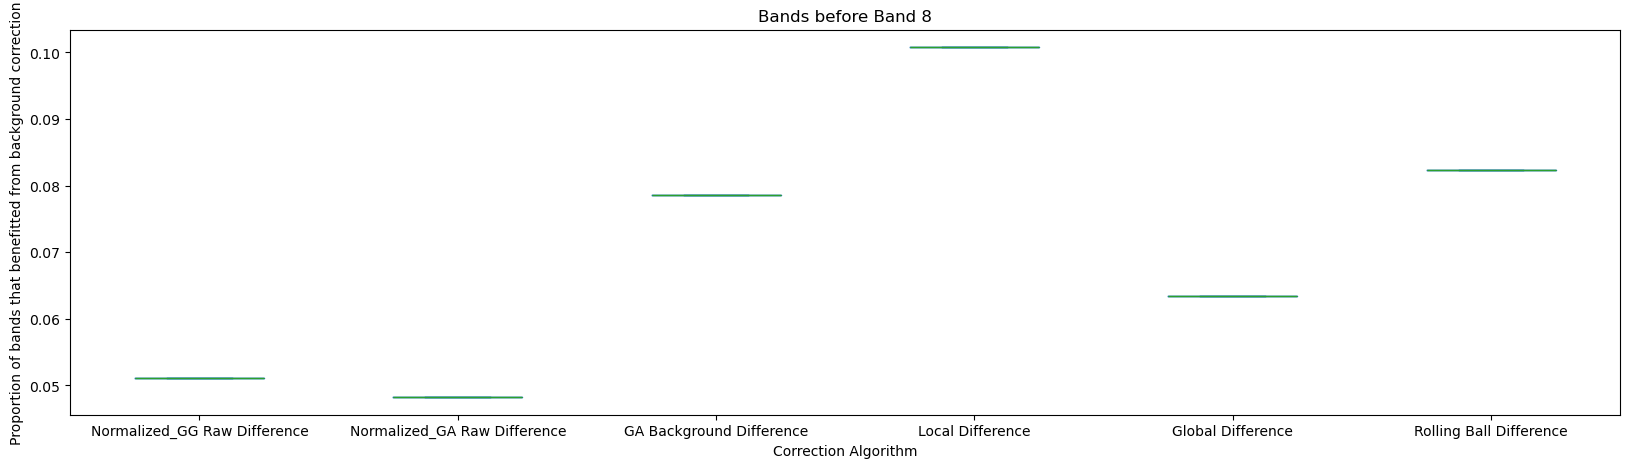

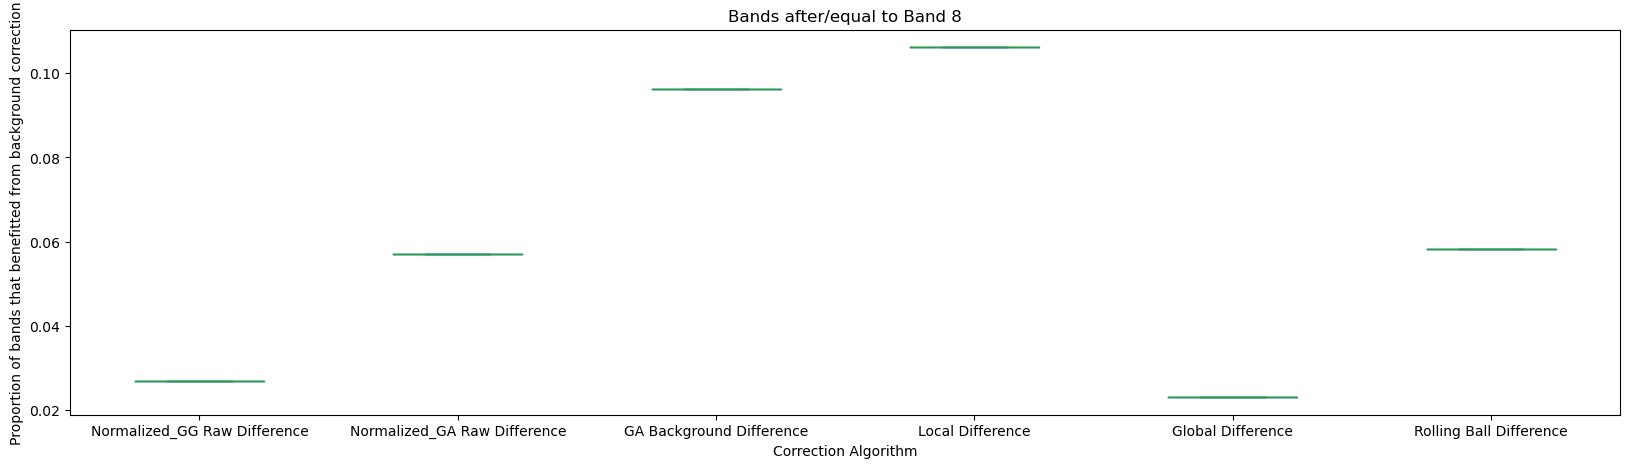

In [10]:
# these graphs are quite interesting - it seems that our method is more successful than GA on the lower bands
sel_quantities = [  'Normalized_GG Raw Difference',
                  'Normalized_GA Raw Difference',
                    'GA Background Difference',
                    'Local Difference', 
                  'Global Difference',
                    'Rolling Ball Difference']

data_package_high = defaultdict(list)
data_package_low = defaultdict(list)

cutoff_band = 8

# for gel in main_df['Gel ID'].unique():
for gel in [13]: # replace here to select specific gel ids
    filt_df = main_df[main_df['Gel ID']==gel]
        
    for i, q in enumerate(sel_quantities):
        data_package_low[q].append(abs(filt_df[filt_df['Band ID'] < cutoff_band][q]).mean())
        data_package_high[q].append(abs(filt_df[filt_df['Band ID'] >= cutoff_band][q]).mean())

out_dict = pd.DataFrame.from_dict(data_package_high) 
fig, ax = plt.subplots(figsize=(20,5))
out_dict.plot(kind='box',ax=ax)
plt.xlabel('Correction Algorithm')
plt.ylabel('Proportion of bands that benefitted from background correction')
plt.title('Bands before Band %s' % cutoff_band)

out_dict = pd.DataFrame.from_dict(data_package_low) 
fig, ax = plt.subplots(figsize=(20,5))
out_dict.plot(kind='box',ax=ax)
plt.xlabel('Correction Algorithm')
plt.ylabel('Proportion of bands that benefitted from background correction')
plt.title('Bands after/equal to Band %s' % cutoff_band)
pass

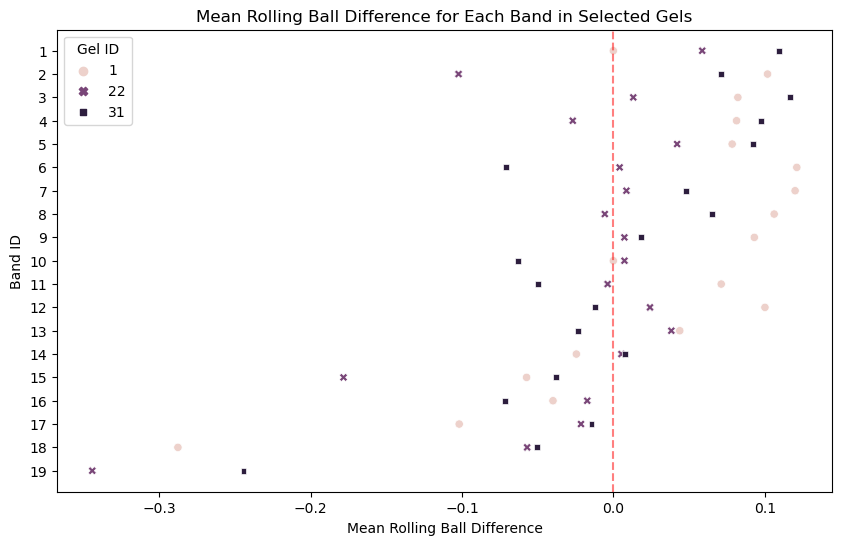

In [47]:
selected_gels = [1, 22, 31]

filtered_df = main_df[main_df['Gel ID'].isin(selected_gels)]

mean_rolling_ball_diff = filtered_df.groupby(['Gel ID', 'Band ID'])['Rolling Ball Difference'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=mean_rolling_ball_diff, x='Rolling Ball Difference', y='Band ID', hue='Gel ID', style='Gel ID')
plt.xlabel('Mean Rolling Ball Difference')
plt.ylabel('Band ID')
plt.yticks(range(1, 20))  
plt.gca().invert_yaxis()  
plt.title('Mean Rolling Ball Difference for Each Band in Selected Gels')
plt.legend(title='Gel ID')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.show()

# Trend suggests that higher bands are overestimated and lower bands are underestimated. And the underestimation is more severe than the overestimation. Lower bands are fainter and have a less defined edge. 

### Unfinished Questions/Tasks

- Are there other parts of the data we could explore?
- What statistical tests can we do to compare distributions?
- How should we present the data?
- Is the data formatting correctly catering for instances where GA has faulty bands or GG has no bands?  I also need to finish the last 3 gels with GA.
- Do we want to take another look at over/under target estimation instead of absolute?
- We should also consider how to present our simplified results in tables, not just graphs 

### Just Debugging Tests

In [11]:
gel_id = 2

sel_quantities = ['Local Corrected Volume', 'Global Corrected Volume', 'Rolling Ball Corrected Volume']
sel_quantities = ['Background Difference','Local Difference', 'Global Difference', 'Rolling Ball Difference']
app = ['GA'] + ['GG'] * 3

filt_df = main_df[main_df['Gel ID']==gel_id]

data = defaultdict(list)

for band in filt_df['Band ID'].unique():
    mean_gg = abs(filt_df[(filt_df['Band ID']==band) & (filt_df['App']=='GG')]['Raw Difference']).mean()
    mean_ga = abs(filt_df[(filt_df['Band ID']==band) & (filt_df['App']=='GA')]['Raw Difference']).mean()
    for i,(s,a) in enumerate(zip(sel_quantities, app)):
        if a == 'GA':
            mean_pt = mean_ga - abs(filt_df[filt_df['Band ID']==band][s]).mean() 
        else:
            mean_pt = mean_gg - abs(filt_df[filt_df['Band ID']==band][s]).mean() 
            
        data[s].append(mean_pt)

df = pd.DataFrame.from_dict(data)   

# Plotting grouped bar chart
ax = df.plot(kind='bar', figsize=(20, 6), rot=0)

# Adding labels and title
plt.xlabel('Band Index')
plt.ylabel('Improvement over raw')
plt.title('Grouped Bar Chart')
# plt.bar(band, mean_pt)
# plt.xticks(range(19))
# plt.xlim([0.5,18.5])

pass

KeyError: 'Background Difference'

In [ ]:
gel_id = 2

sel_quantities = ['Local Corrected Volume', 'Global Corrected Volume', 'Rolling Ball Corrected Volume']
sel_quantities = ['Background Difference','Local Difference', 'Global Difference', 'Rolling Ball Difference']
app = ['GA'] + ['GG'] * 3

filt_df = main_df[main_df['Gel ID']==gel_id]

data = defaultdict(list)

for band in filt_df['Band ID'].unique():
    mean_gg = abs(filt_df[(filt_df['Band ID']==band) & (filt_df['App']=='GG')]['Raw Difference']).mean()
    mean_ga = abs(filt_df[(filt_df['Band ID']==band) & (filt_df['App']=='GA')]['Raw Difference']).mean()
    for i,(s,a) in enumerate(zip(sel_quantities, app)):
        if a == 'GA':
            mean_pt = mean_ga - abs(filt_df[filt_df['Band ID']==band][s]).mean() 
        else:
            mean_pt = mean_gg - abs(filt_df[filt_df['Band ID']==band][s]).mean() 
            
        data[s].append(mean_pt)

df = pd.DataFrame.from_dict(data)   

# Plotting grouped bar chart
ax = df.plot(kind='bar', figsize=(20, 6), rot=0)

# Adding labels and title
plt.xlabel('Band Index')
plt.ylabel('Improvement over raw')
plt.title('Grouped Bar Chart')
# plt.bar(band, mean_pt)
# plt.xticks(range(19))
# plt.xlim([0.5,18.5])

pass

In [ ]:
gel_id = 2

sel_quantities = ['Normalized_Local Corrected Volume', 'Normalized_Global Corrected Volume', 'Normalized_Rolling Ball Corrected Volume']
# sel_quantities = ['Raw GG','Raw GA','Background Difference','Local Difference', 'Global Difference', 'Rolling Ball Difference']

filt_df = main_df[main_df['Gel ID']==gel_id]

data = defaultdict(list)

for band in filt_df['Band ID'].unique():
    for i, q in enumerate(sel_quantities):
        if q == 'Raw GG':
            mean_pt = abs(filt_df[(filt_df['Band ID']==band) & (filt_df['App']=='GG')]['Raw Difference']).mean()
        elif q == 'Raw GA':
            mean_pt = abs(filt_df[(filt_df['Band ID']==band) & (filt_df['App']=='GA')]['Raw Difference']).mean()
        else:
            mean_pt = abs(filt_df[filt_df['Band ID']==band][q]).mean()
        data[q].append(mean_pt)

df = pd.DataFrame.from_dict(data)   

plt.figure(figsize=(20,5))
# Plotting grouped bar chart
ax = df.plot(kind='bar', figsize=(10, 6), rot=0)

# Adding labels and title
plt.xlabel('Band Index')
plt.ylabel('Error')
plt.title('Grouped Bar Chart')
# plt.bar(band, mean_pt)
# plt.xticks(range(19))
# plt.xlim([0.5,18.5])

pass